In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from keras import backend as K

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
folder_benign_train = '/content/gdrive/MyDrive/Colab Notebooks/input/data/train/benign'
folder_malignant_train = '/content/gdrive/MyDrive/Colab Notebooks/input/data/train/malignant'

folder_benign_test = '/content/gdrive/MyDrive/Colab Notebooks/input/data/test/benign'
folder_malignant_test = '/content/gdrive/MyDrive/Colab Notebooks/input/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

In [5]:
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

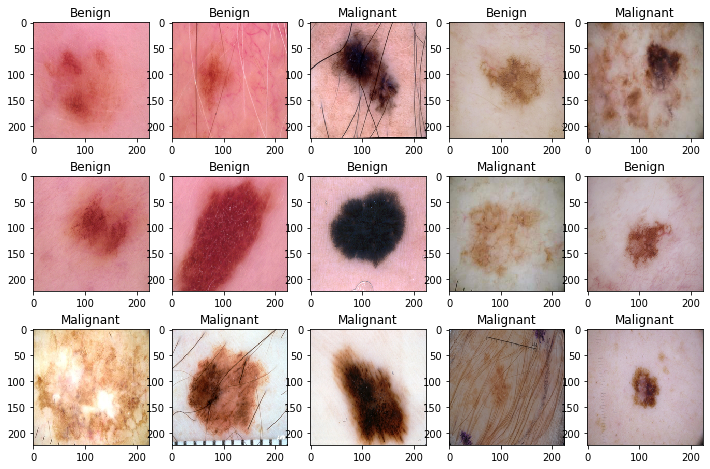

In [6]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [7]:
#Categorical Labels

y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [8]:
#Normalization
#Normalize all Values of the pictures by dividing all the RGB values by 255

# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

In [9]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=1e-7)

In [10]:
#VGG16
#The CNN above is not a very sophisticated model, thus the VGG16, is also tried

input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = VGG16(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

Epoch 1/50
33/33 [==============================] - 68s 1s/step - loss: 0.6918 - accuracy: 0.5248 - val_loss: 0.6834 - val_accuracy: 0.5360
Epoch 2/50
33/33 [==============================] - 31s 928ms/step - loss: 0.6703 - accuracy: 0.5497 - val_loss: 0.6049 - val_accuracy: 0.6212
Epoch 3/50
33/33 [==============================] - 30s 909ms/step - loss: 0.5542 - accuracy: 0.7092 - val_loss: 0.5417 - val_accuracy: 0.7064
Epoch 4/50
33/33 [==============================] - 30s 901ms/step - loss: 0.4878 - accuracy: 0.7592 - val_loss: 0.4769 - val_accuracy: 0.7822
Epoch 5/50
33/33 [==============================] - 30s 916ms/step - loss: 0.4417 - accuracy: 0.7882 - val_loss: 0.4676 - val_accuracy: 0.7860
Epoch 6/50
33/33 [==============================] - 30s 921ms/step - loss: 0.4556 - accuracy: 0.7857 - val_loss: 0.4928 - val_accuracy: 0.7538
Epoch 7/50
33/33 [==============================] - 30s 914ms/step - loss: 0.4554 - accuracy: 0.7814 - val_loss: 0.5425 - val_accuracy: 0.7197
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


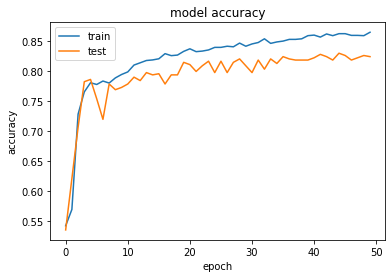

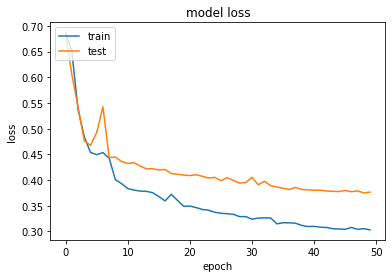

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=1,
          callbacks=[learning_rate_reduction]
         )

Epoch 1/50
53/53 [==============================] - 66s 977ms/step - loss: 0.3200 - accuracy: 0.8529
Epoch 2/50
53/53 [==============================] - 38s 723ms/step - loss: 0.3167 - accuracy: 0.8567
Epoch 3/50
53/53 [==============================] - 39s 730ms/step - loss: 0.3154 - accuracy: 0.8548
Epoch 4/50
53/53 [==============================] - 39s 727ms/step - loss: 0.3150 - accuracy: 0.8563
Epoch 5/50
53/53 [==============================] - 39s 728ms/step - loss: 0.3147 - accuracy: 0.8567
Epoch 6/50
53/53 [==============================] - 39s 729ms/step - loss: 0.3139 - accuracy: 0.8582
Epoch 7/50
53/53 [==============================] - 39s 728ms/step - loss: 0.3146 - accuracy: 0.8548
Epoch 8/50
53/53 [==============================] - 39s 729ms/step - loss: 0.3143 - accuracy: 0.8544
Epoch 9/50
53/53 [==============================] - 39s 728ms/step - loss: 0.3139 - accuracy: 0.8570
Epoch 10/50
53/53 [==============================] - 39s 729ms/step - loss: 0.3148 - accura

In [13]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

0.8409090909090909
Saved model to disk


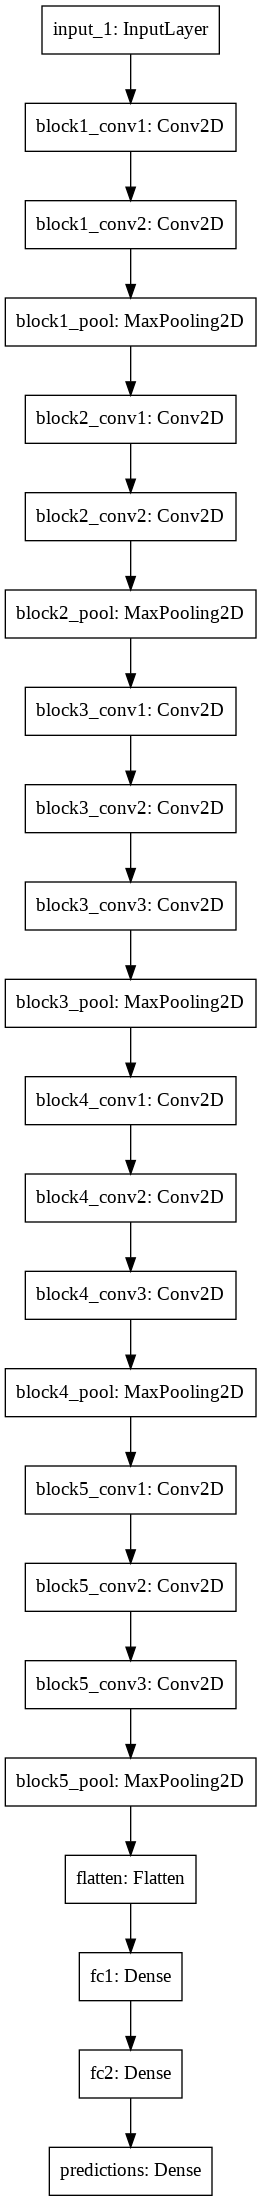

In [14]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [26]:
from sklearn.metrics import confusion_matrix
import pandas as pd
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
conf_mat = pd.DataFrame(matrix, ["Benign", "Malignant"], ["Benign", "Malignant"])
#y_pred = np.argmax(y_test, axis=1)
print('Confusion Matrix')
conf_mat

Confusion Matrix


,Benign,Malignant
Benign,292,68
Malignant,37,263
